**Učitavanje slika**

U Pythonu postoji mnogo različitih načina za učitavanje slika. TorchVision predstavlja sjajno rešenje koje nudi PyTorch ali pre toga prolazimo manje zahtevnu implementaciju pomoću imageio modula koji ima uniformni API.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import imageio
img_arr = imageio.imread('/content/drive/MyDrive/Colab Notebooks/Izabrana poglavlja iz OS 2022 23/test kolor slike/lena_color.png')
img_arr.shape

(512, 512, 3)


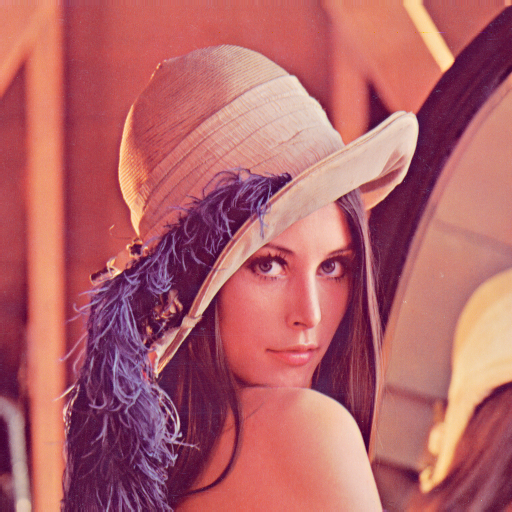

In [4]:
import plotly.express as px
fig = px.imshow(img_arr)
fig.show()

In [5]:
fig = px.imshow(img_arr[:,:,2], color_continuous_scale='gray') # prikaz jednog kanala RGB slike
fig.show()

img objekat u ovom trenutku je sličan NumPy nizu sa 3 dimenzije. Prve dve dimenzije su visina i širina slike, dok treća dimenzija odgovara crvenom, zelenom i plavom kanalu (RGB). Bilo koja biblioteka koja daje NumPy zapis može da se transformiše u PyTorch tenzor, samo je bitno voditi računa o rasporedu dimenzija. PyTorch modul koji vrši procesiranje slike zahteva da raspored tenzora bude C × H × W (kanali, visina, širina).

Kako je izlaz img objekta takav da je raspored dimenzija H × W × C, potrebno je izvršiti permutaciju kako bismo dobili zahtevani raspored. 

In [7]:
import torch
img = torch.from_numpy(img_arr)
out = img.permute(2, 0, 1)

**Učitavanje skupa slika iz foldera**

Koristeći sličnu strategiju, organizujmo skup slika koji može služiti kao ulaz za neuronsku mrežu. Slike skladištimo duž prve dimenzije tako da dobijamo tenzor N × C × H × W , gde N predstavlja broj slika u skladištu (eng. batch size). Promenljiva koju dobijamo sadrži informacije o nekoliko slika u formi tenzora i takvu promenljivu nazivamo batch.

In [8]:
batch_size = 3
batch = torch.zeros(batch_size, 3, 512, 512, dtype=torch.uint8)

Ovakav kod ukazuje na to da očekujemo na ulazu 3 RGB slike prostorne rezolucije 512 × 512 piksela, gde je svaka boja zapisana u memoriji uint8 tipom. 
Kako bismo učitali slike iz foldera, importujemo os biblioteku koja nam omogućava interakciju sa datotekama. Navodimo lokaciju foldera u promenljivu data_dir a zatim vraćamo nazive svih datoteka koje imaju png format.

Pogodan način za pristup datotekama unutar nekog foldera možemo dobiti korišćenjem enumerate() funkcije u Pythonu. Koristi se na sličan način u for petljama kao i bilo koji drugi prebrojivi objekat.

Podsetimo se načina korišćenja for petlje.

In [9]:
for index in range(5):
  print(index)

0
1
2
3
4


In [10]:
values = ["a", "b", "c"]
for value in values:
  print(value)


a
b
c


In [11]:
index = 0
values = ["a", "b", "c"]
for value in values:
    print(index, value)
    index += 1

0 a
1 b
2 c


Funkcija enumerate() vraća 2 promeljive u petlji: broj trenutne iteracije i
vrednost stavke u trenutnoj iteraciji

In [12]:
values = ["a", "b", "c"]
for count, value in enumerate(values):
    print(count, value)

0 a
1 b
2 c


Ovakav pristup možemo primeniti za izlistavanje svih datoteka u nekom folderu, pri čemu bi se count odnosio na redni broj datoteke a value na njen naziv. Pored toga, možemo uvesti i dodatni uslov kako bismo bili sigurni da datoteke neželjenih formata neće ući u proces nabrajanja, za slučaj da nismo lepo organizovali sastav datoteka u folderu.

In [13]:
import os
data_dir = '/content/drive/MyDrive/Colab Notebooks/Izabrana poglavlja iz OS 2022 23/test kolor slike'
filenames = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.png'] # kreiranje niza koji sadrži imena datoteka i provera tipa podataka unutar foldera pomoću if-a.
for i, filename in enumerate(filenames):
  #print(i)
  #print(filename)
  img_arr = imageio.imread(os.path.join(data_dir, filename))
  fig = px.imshow(img_arr)
  fig.show()
  img_t = torch.from_numpy(img_arr)
  img_t = img_t.permute(2, 0, 1)
  img_t = img_t[:3]
  batch[i] = img_t
  


Output hidden; open in https://colab.research.google.com to view.

**Normalizacija podataka**

Neuralne mreže najčešće rade s tenzorima zapisanim kao floating point na svom ulazu (full precision 32 bita). Međutim, najbolje performanse u procesu treniranja se ostvaraju u slučaju kada su podaci raspodeljeni na opseg od 0 do 1 ili od -1 do 1. U praksi to znači da je potrebno denormalizovati vrednosti piksela slike na neki od željenih opsega i preći na floating point tip. U slučaju da su ulazne slike uint8 tipa (boje su predstavljene u opsegu 0-255), denormalizacija se može izvršiti tako što podelimo intenzitete boja piksela sa 255. 

In [14]:
batch = batch.float()
batch /= 255.0

Druga mogućnost je da se izračuna srednja vrednost i standardna devijacija ulaznih podataka i da se skaliraju tako da izlaz ima nultu srednju vrednost i jediničnu standardnu devijaciju na svakom kanalu:

In [15]:
n_channels = batch.shape[1]
for c in range(n_channels):
  mean = torch.mean(batch[:, c])
  std = torch.std(batch[:, c])
  batch[:, c] = (batch[:, c] - mean) / std

In [16]:
print(batch.shape)

torch.Size([3, 3, 512, 512])


**Učitavanje DICOM formata**

Za razliku od klasičnih 2D slika dobijenih kamerama široke potrošnje, medicinske primene često zahtevaju snimke organa iz više uglova. U slučaju kompjuterske tomografije (CT), uređaj pravi snimke nekoliko preseka (slojeva) pomoću X zraka. Skladištenjem 2D slika snimljenih u više preseka dobijamo 3D tenzor. Pored prostorne rezolucije 2D preseka, tenzor sadrži i informaciju o rednom broju snimljenog preseka. Ovako organizovane medicinske slike se u literaturi nazivaju i 3D slikama. Kombinacija svih preseka čini *volume*, pa za učitavanje ovakvih slika koristimo odgovarajuću volumetrijsku funkciju volread() iz imageio paketa.

In [19]:
dir_path = "/content/drive/MyDrive/Colab Notebooks/Izabrana poglavlja iz OS 2022 23/DICOM slike/volumetric-dicom"
vol_arr = imageio.volread(dir_path, 'DICOM')
vol_arr.shape

Reading DICOM (examining files): 1/99 files (1.0%)2/99 files (2.0%)3/99 files (3.0%)4/99 files (4.0%)5/99 files (5.1%)6/99 files (6.1%)7/99 files (7.1%)8/99 files (8.1%)9/99 files (9.1%)10/99 files (10.1%)11/99 files (11.1%)12/99 files (12.1%)13/99 files (13.1%)14/99 files (14.1%)15/99 files (15.2%)16/99 files (16.2%)17/99 files (17.2%)18/99 files (18.2%)19/99 files (19.2%)20/99 files (20.2%)21/99 files (21.2%)22/99 files (22.2%)23/99 files (23.2%)24/99 files (24.2%)25/99 files (25.3%)26/99 files (26.3%)27/99 files (27

(99, 512, 512)

In [20]:
vol_arr.shape

(99, 512, 512)

Proverom shape-a vidimo da ne postoji informacija o kanalu. Kako je raspored u tenzoru drugačiji nego što to očekuje PyTorch, moramo dodati informaciju o kanalu pomoću funkcije unsqueeze().

In [21]:
vol = torch.from_numpy(vol_arr).float()
vol = torch.unsqueeze(vol, 0)
vol.shape

torch.Size([1, 99, 512, 512])

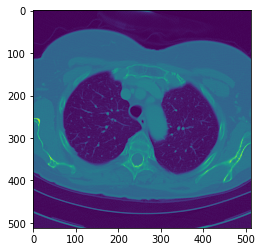

In [22]:
import matplotlib.pyplot as plt

plt.imshow(vol_arr[21]) # prikaz slike nakon učitavanja imageio paketom


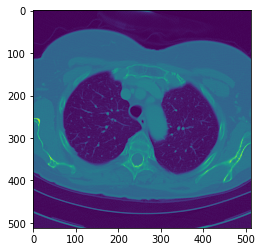

In [23]:
plt.imshow(vol[0,21]) # prikaz slike nakon permutacija, tj. nakon organizovanja u odgovarajući torch tenzor.

Prikazivanje više slika pomoću subplota.

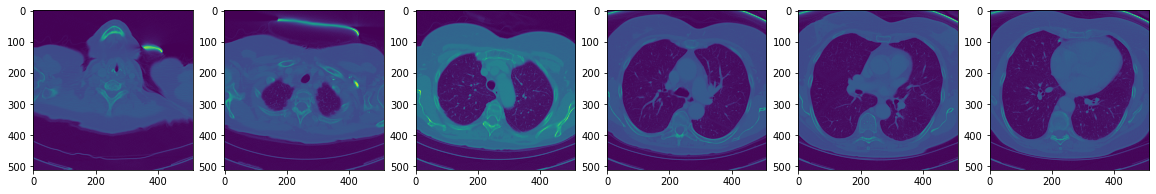

In [24]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 4))
for i in range(6) :
 ax = fig.add_subplot(1, 6, i+1)
 ax.imshow(vol[0, i+i*10])

**torchvision paket**

Drugi način za učitavanje slika moguć je korišćenjem torchivision paketa. Torchvision predstavlja PyTorch paket koji omogućava lakši rad u oblasti kompjuterske vizije. Paket pruža pristup poznatim bazama slika za treniranje, pretreniranim modelima neuralnih mreža a pored toga omogućava i jednostavno učitavanje i snimanje slika kao i neke poznate transformacije.

In [26]:
import torchvision

tsr_img = torchvision.io.read_image('/content/drive/MyDrive/Colab Notebooks/Izabrana poglavlja iz OS 2022 23/test kolor slike/lena_color.png')
tsr_img.shape

torch.Size([3, 512, 512])

Možemo primetiti da pomoću torchvision modula dobijamo tenzor kakav se i zahteva PyTorch modulom, tj. raspored unutar tenzora je C × H × W (kanali, visina, širina). To znači da nije potrebno vršiti permutacije dimenzija kako bismo dalje koristili ovakav tenzor za rad sa neuralnim mrežama. Međutim, ukoliko želimo da prikažemo sliku pomoću matplotlib paketa, permutacije su neophodne.

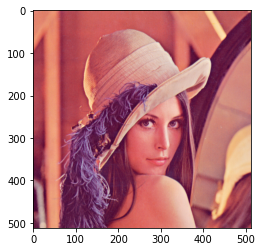

In [27]:
import matplotlib.pyplot as plt

plt.imshow(tsr_img.permute((1,2,0)))

Učitavanje foldera pomoću torchvision paketa se obavlja na sličan način kao i pomoću imageio paketa. 

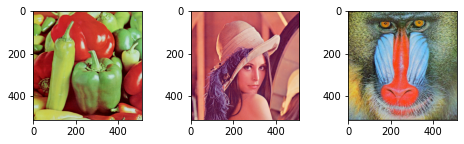

In [28]:
import os

data_dir = '/content/drive/MyDrive/Colab Notebooks/Izabrana poglavlja iz OS 2022 23/test kolor slike'

filenames = [name for name in os.listdir(data_dir) if os.path.splitext(name)[-1] == '.png']

import torch

batch_size = len(filenames)
batch = torch.zeros(batch_size, 3, 512, 512, dtype=torch.uint8) #inicijalizacija tenzora

for i, filename in enumerate(filenames):
 batch[i] = torchvision.io.read_image(os.path.join(data_dir, filename))

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 2))
for i in range(batch.shape[0]) :
 ax = fig.add_subplot(1, 3, i+1)
 ax.imshow(batch[i].permute(1, 2, 0))

#plt.imshow(batch[0].permute(1, 2, 0))

Batch možemo kreirati i pomoću stack() funkcije, ali je ovakav pristup manje pogodan za rad sa velikim brojem slika. 

In [29]:
tsr_img1 = torchvision.io.read_image('/content/drive/MyDrive/Colab Notebooks/Izabrana poglavlja iz OS 2022 23/test kolor slike/lena_color.png')
tsr_img2 = torchvision.io.read_image('/content/drive/MyDrive/Colab Notebooks/Izabrana poglavlja iz OS 2022 23/test kolor slike/baboon.png')
batch = torch.stack([tsr_img1, tsr_img2])

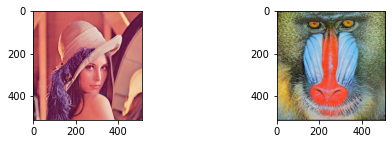

In [30]:
fig = plt.figure(figsize=(8, 2))
for i in range(batch.shape[0]):
 ax = fig.add_subplot(1, 2, i+1)
 ax.imshow(batch[i].permute(1, 2, 0))